In [1]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp, bases_poly_2D_s_a_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [2]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [3]:
def reward(traj_mat, act_mat):
    # traj_mat shape: (m, I, dim)
    # act_mat shape: (m, I, dim)
    # output shape: (m, I, 1)
    r_1 = torch.einsum("ijk,kl,ijl->ij", traj_mat, Q, traj_mat)
    r_2 = torch.einsum("ijk,kl,ijl->ij", act_mat, R, act_mat)
    return (- r_1 - r_2).unsqueeze(-1)

In [4]:
beta = 1e-2
sig = 1.
A = torch.tensor([[-9.3750, -3.1250], [-3.1250, -9.3750]])
B = torch.tensor([[10., 1.], [1., 10.1]])
Q = torch.tensor([[10., 2.], [2., 10.4]])
R = torch.tensor([[12., 3.], [3., 8.]])

In [5]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [6]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.3993,  0.1253],
        [ 0.1162, -0.5848]])
tensor([[0.],
        [0.]])
tensor([-8.7381e+01, -4.2778e-01,  3.5272e-02, -4.4603e-01])
tensor([-147.3232,   -0.6342,   -0.4598,   -0.8390])


In [7]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = False
deterministic = True
b_val_phibe, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


In [8]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simp_basis = False
deterministic = True
b_val_phibe, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


In [9]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 2
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running Optimal BE PI: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


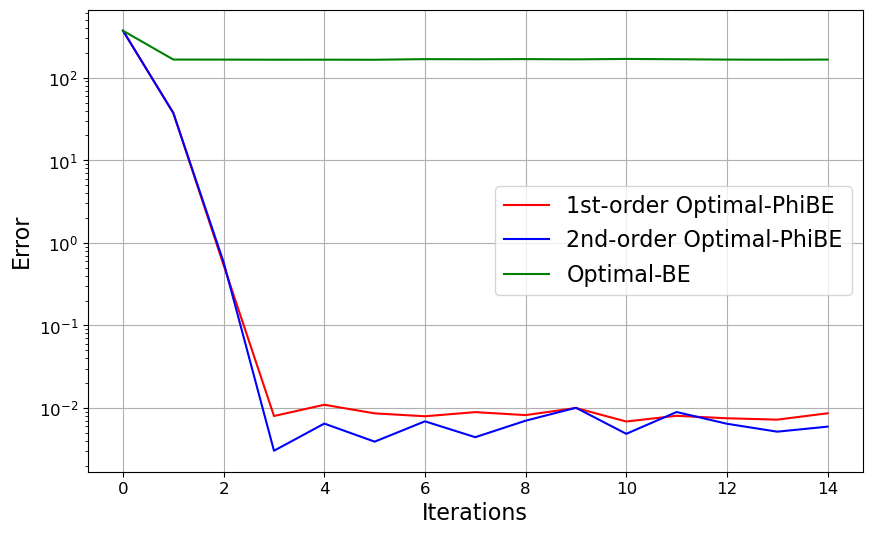

In [10]:
x_tensor = torch.arange(15)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:15], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:15], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:15], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='1st-order Optimal-PhiBE', color='red')
plt.semilogy(x_values, y_values, label='2nd-order Optimal-PhiBE', color='blue')
plt.semilogy(x_values, v_values, label='Optimal-BE', color='green')
# plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.savefig("LQR/2d_s/1.eps", format='eps')
plt.show()

In [294]:
beta = 0.01
sig = 1.
A = torch.tensor([[-1.8750, -0.6250], [-0.6250, -1.8750]])
B = torch.tensor([[0.6, 0.2], [0.2, 0.6]])
Q = torch.tensor([[10., 2.], [2., 10.4]])
R = torch.tensor([[12., 3.], [3., 8.]])

In [295]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [296]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.1330,  0.0256],
        [ 0.0112, -0.2104]])
tensor([[0.],
        [0.]])
tensor([-554.7285,   -2.8102,    0.7937,   -2.7371])
tensor([-828.8245,   -4.0689,    2.6561,   -4.2194])


In [303]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


In [304]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin:   0%|          | 0/15 [00:00<?, ?it/s]

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


In [305]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running Optimal BE PI: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


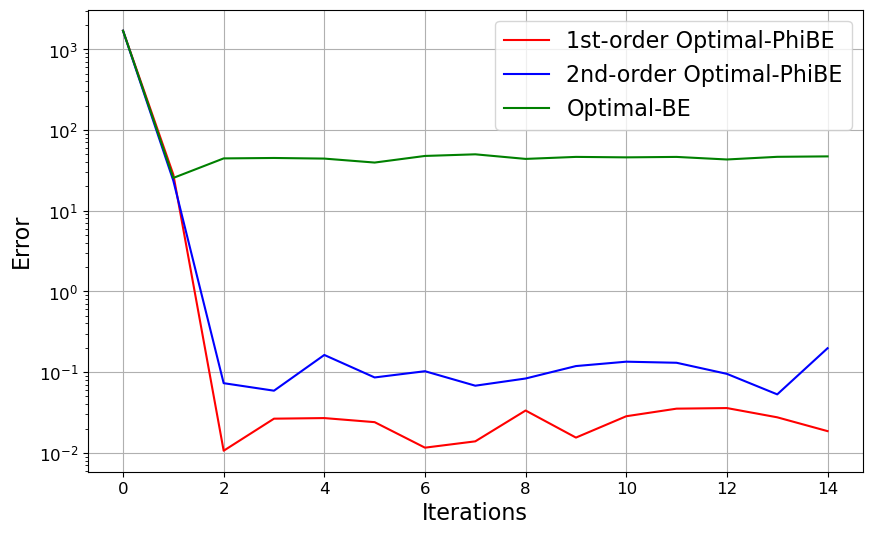

In [306]:
x_tensor = torch.arange(15)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:15], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:15], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:15], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='1st-order Optimal-PhiBE', color='red')
plt.semilogy(x_values, y_values, label='2nd-order Optimal-PhiBE', color='blue')
plt.semilogy(x_values, v_values, label='Optimal-BE', color='green')
# plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.savefig("LQR/2d_s/2.eps", format='eps')
plt.show()

In [284]:
beta = 0.01
sig = 1.
A = torch.tensor([[-9.3750, -3.1250], [-3.1250, -9.3750]])
B = torch.tensor([[1., 0.1], [0.1, 1.01]])
Q = torch.tensor([[106.6667, -93.3333], [-93.3333, 106.6667]])
R = torch.tensor([[9., 8.5], [8.5, 9.]])

In [286]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 0.5 * torch.randn(2, 2)
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [287]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-7.1387,  7.1081],
        [ 7.1072, -7.1439]])
tensor([[0.],
        [0.]])
tensor([-840.4699,   -4.2011,    7.3400,   -4.2036])
tensor([-863.5371,   -4.4254,    7.3989,   -4.2100])


In [289]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


In [292]:
bd_low_s = -5
bd_upper_s = 5
bd_low_b = -10
bd_upper_b = 10
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


In [291]:
bd_low_s = -5
bd_upper_s = 5
bd_low_a = -10
bd_upper_a = 10
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running Optimal BE PI: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


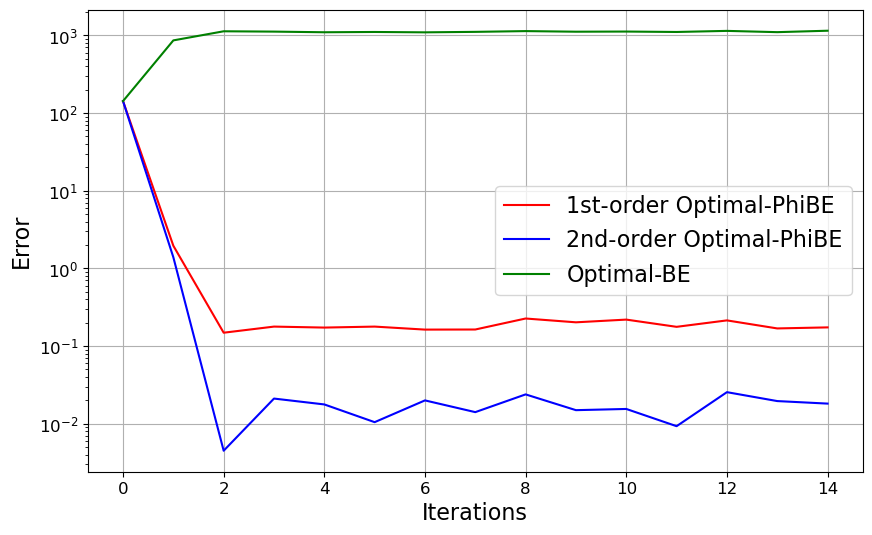

In [293]:
x_tensor = torch.arange(15)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:15], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:15], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:15], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='1st-order Optimal-PhiBE', color='red')
plt.semilogy(x_values, y_values, label='2nd-order Optimal-PhiBE', color='blue')
plt.semilogy(x_values, v_values, label='Optimal-BE', color='green')
# plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.savefig("LQR/2d_s/3.eps", format='eps')
plt.show()

In [130]:
beta = 0.01
sig = 1.
A = torch.tensor([[10.6667, -9.3333], [-9.3333, 10.6667]])
B = torch.tensor([[0.9000, 0.8500], [0.8500, 0.8800]])
Q = torch.tensor([[12.,  3.], [ 3.,  8.]])
R = torch.tensor([[10.0000,  2.0000], [ 2.0000, 10.4000]])

In [224]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + 25 * torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [226]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-559.6524,  558.7028],
        [ 408.9503, -411.7854]])
tensor([[0.],
        [0.]])
tensor([-19807892.6661,    -99245.8275,    198049.8014,    -98833.0991])
tensor([-20556961.0377,   -103481.1110,    205069.8366,   -102088.4994])


In [231]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = False
deterministic = True
b_val_phibe_1, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


In [251]:
bd_low_s = -500
bd_upper_s = 500
bd_low_b = -600
bd_upper_b = 600
reward = reward
bases_V = bases_poly_2D
d_bases_V = d_bases_poly_2D
sec_d_bases_V = sec_d_bases_poly_2D
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
lr=0.1
order = 2
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = False
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 2 using Galerkin: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


In [233]:
bd_low_s = -500
bd_upper_s = 500
bd_low_a = - 600
bd_upper_a = 600
reward = reward
bases_Q = bases_poly_2D_s_a
num_iter = 15
GD_num_iter = 75
m=int(1e4)
m_Q=int(1e4)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simple_basis = False
b_val_RL, V_exact_dist_RL = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running Optimal BE PI:   0%|          | 0/15 [00:00<?, ?it/s]

Running Optimal BE PI: 100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


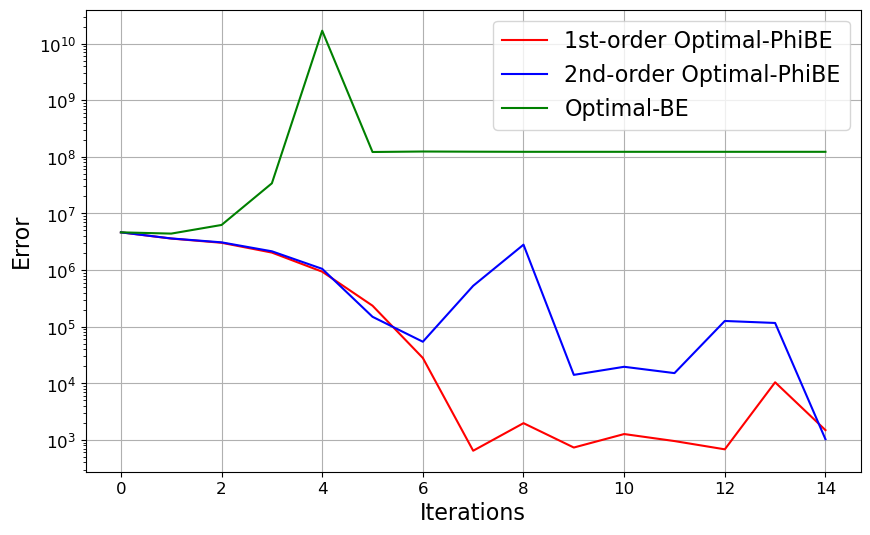

In [252]:
x_tensor = torch.arange(15)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:15], dtype=torch.float64)
y_tensor = torch.tensor(V_exact_dist_phibe_2[:15], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL[:15], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
y_values = y_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='1st-order Optimal-PhiBE', color='red')
plt.semilogy(x_values, y_values, label='2nd-order Optimal-PhiBE', color='blue')
plt.semilogy(x_values, v_values, label='Optimal-BE', color='green')
# plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.savefig("LQR/2d_s/4.eps", format='eps')
plt.show()